# Classification with GPU-quantum embedding kernels on Covalent Cloud

Quantum support-vector machines (QSVMs) are essentially [traditional SVMs](https://en.wikipedia.org/wiki/Support_vector_machine) that rely on [embedding kernels](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) evaluated on a quantum computer—a.k.a. [*quantum embedding kernel*](https://pennylane.ai/qml/demos/tutorial_kernels_module/#training-and-evaluating-quantum-kernels). These kernels provide a unique (and perhaps classically-intractable) means of measuring pairwise similarity.

Using GPUs to simulate quantum computers is worthwhile when qubit capacity and/or fidelity requirements are not met by the available quantum hardware. While QSVMs are relatively tolerant to noise (an important reason for their current popularity), evaluating kernels on *real* quantum hardware is not always practical nor necessary.

In this tutorial, we’ll demonstrate how to run GPU-accelerated quantum circuit simulations on Covalent Cloud.

Let’s start by importing the required packages. 

In [1]:
import covalent as ct
import covalent_cloud as cc
import matplotlib.pyplot as plt
import pennylane as qml
from matplotlib.colors import ListedColormap
from pennylane import numpy as np
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# cc.save_api_key("YOUR_API_KEY")

Covalent Cloud allows us to create [re-usable execution environments](https://docs.covalent.xyz/docs/cloud/guides/cloud_custom_environments/), as shown below. This environment represents a typical setup for running Pennylane on NVIDIA GPUs.

In [2]:
cc.create_env(
    name="pennylane-gpu",  # identifier for referring to this environment
    conda={
        "channels": ["conda-forge"],
        "dependencies": ["cudatoolkit>=11.8"],
    }, pip=[
        "cuquantum==23.10.0",
        "matplotlib==3.8.2",
        "Pennylane==0.34.0",
        "PennyLane-Lightning[GPU]==0.34.0",
        "scikit-learn==1.3.1",
        "torch==2.1.2",
    ],
    wait=True
)

Waiting for environment pennylane-gpu to be ready............................................................................................................................................................................
Name: pennylane-gpu
Status: READY
Estimated Time: 1002 seconds
Notes:
	pip was added to the dependencies.
	Python version 3.10 was added to the dependencies.
Environment file contains:
channels:
- conda-forge
dependencies:
- python=3.10
- pip
- cudatoolkit>=11.8
- pip:
  - cuquantum==23.10.0
  - matplotlib==3.8.2
  - Pennylane==0.34.0
  - PennyLane-Lightning[GPU]==0.34.0
  - scikit-learn==1.3.1
  - torch==2.1.2
  - covalent-cloud
name: pennylane-gpu



Next, we'll define our resource specifications by creating some [executors](https://docs.covalent.xyz/docs/user-documentation/api-reference/executors/cloud_executor) for this workflow. Both executors will run tasks in our new environment, named `”pennylane-gpu”`.

In [3]:
cpu_executor = cc.CloudExecutor(  # for lightweight non-quantum tasks
    env="pennylane-gpu",
    num_cpus=2,
    memory="2GB",
)
gpu_executor = cc.CloudExecutor(  # for GPU-powered circuit simulations
    env="pennylane-gpu",
    num_cpus=4,
    memory="12GB",
    num_gpus=1,
    gpu_type="v100"
)

On to the algorithm!

Here's a function returns a simple quantum kernel based on Pennylane's [IQP Embedding](https://docs.pennylane.ai/en/stable/code/api/pennylane.IQPEmbedding.html) template. We'll use it as-is inside our workflow.

In [4]:
QML_DEVICE = "lightning.qubit"

def get_kernel_circuit(n_wires):

    @qml.qnode(qml.device(QML_DEVICE, wires=n_wires, shots=None))
    def circuit(x1, x2):
        qml.IQPEmbedding(x1, wires=range(n_wires), n_repeats=4)
        qml.adjoint(qml.IQPEmbedding)(x2, wires=range(n_wires), n_repeats=4)
        return qml.probs(wires=range(n_wires))

    return lambda x1, x2: circuit(x1, x2)[0]  # |0..0> state probability

Next, each function destined for remote execution is decorated with `@ct.electron`, with an [executor](https://docs.covalent.xyz/docs/user-documentation/api-reference/executors/cloud_executor) specified therein. Only tasks that evaluate the simulated quantum kernel should require `gpu_executor`. For example, we don't need GPUs to generate our input data:

In [5]:
@ct.electron(executor=cpu_executor)  # lightweight non-quantum task
def get_split_data(n_samples=18, test_size=0.2):
    centers = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
    X, y = make_blobs(n_samples, centers=centers, cluster_std=0.25, shuffle=False)
    # rescale labels to be -1, 1
    mapping = {0: -1, 1: 1, 2: -1, 3: 1, 4: -1, 5: 1, 6: -1, 7: 1, 8: -1}
    y = np.array([mapping[i] for i in y])
    X = X.astype(np.float32)
    y = y.astype(int)

    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=test_size, random_state=3)

Classifying with the SVM, on the other hand, requires $O(n^2)$ kernel evaluations, where $n$ is the dataset size. Accordingly, we'll use GPUs (i.e. `gpu_executor`) to speed up this process.

In [6]:
DISP_SETTINGS = {"grid_resolution": 50, "response_method": "predict", "alpha": 0.5, "cmap": plt.cm.RdBu}

@ct.electron(executor=gpu_executor)
def classify_with_qsvm(Xtr, Xte, ytr, yte):
    kernel = get_kernel_circuit(n_wires=Xtr.shape[1])

    kernel_matrix_fn = lambda X, Z: qml.kernels.kernel_matrix(X, Z, kernel)
    svc = SVC(kernel=kernel_matrix_fn).fit(Xtr, ytr)

    # train/test accuracy
    accuracy_tr = svc.score(Xtr, ytr)
    accuracy_te = svc.score(Xte, yte)

    # decision boundary
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    disp = DecisionBoundaryDisplay.from_estimator(svc, Xte, **DISP_SETTINGS)
    disp.ax_.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, cmap=cm_bright)
    disp.ax_.scatter(Xte[:, 0], Xte[:, 1], c=yte, cmap=cm_bright, marker="$\u25EF$")

    return accuracy_tr, accuracy_te, disp

Putting it all together, we can define a QSVM training and testing workflow. This special function gets decorated with `@ct.lattice`.

In [7]:
@ct.lattice(workflow_executor=cpu_executor, executor=cpu_executor)
def run_qsvm(n_samples, test_size):
    Xtr, Xte, ytr, yte = get_split_data(n_samples, test_size)
    return classify_with_qsvm(Xtr, Xte, ytr, yte)

Now, to dispatch `run_qsvm` to Covalent Cloud, we call it after wrapping with `ct.dispatch`, as usual.

In [8]:
dispatch_id = cc.dispatch(run_qsvm)(n_samples=64, test_size=0.2)
print("Dispatch ID:", dispatch_id)

/Users/neptune/anaconda3/envs/qml/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Dispatch ID: 0b5d3a08-fe9c-4dc2-910b-0be6eb925663


Here's what we get when we query and display the results.

/Users/neptune/anaconda3/envs/qml/lib/python3.10/site-packages/covalent/_workflow/transportable_object.py:205: UserWarning: This figure was saved with matplotlib version 3.8.2 and is unlikely to function correctly.
  return cloudpickle.loads(base64.b64decode(self._object.encode("utf-8")))


Train accuracy: 64.7%
Test accuracy: 76.9%


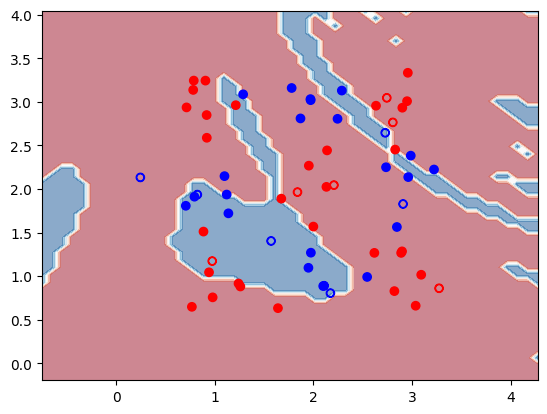

In [10]:
result = cc.get_result(dispatch_id, wait=True)
result.result.load()

train_acc, test_acc, decision_boundary_figure = result.result.value
print(f"Train accuracy: {train_acc * 100:.1f}%")
print(f"Test accuracy: {test_acc * 100:.1f}%")

decision_boundary_figure

# Conclusion

In this tutorial, we demonstrated how to run quantum circuit simulations on GPUs via Covalent Cloud. We used Pennylane to define a simple quantum kernel, and then trained and tested a QSVM on a 2-dimensional dataset. To make the most of this tutorial, try experimenting with different datasets/kernels or increasing the dataset dimension, to gain a greater advantage from GPU acceleration.

The cost of running this workflow is approximately $0.27. The full code is available below.

## Full Code

```python
import covalent as ct
import covalent_cloud as cc
import matplotlib.pyplot as plt
import pennylane as qml
from matplotlib.colors import ListedColormap
from pennylane import numpy as np
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cc.save_api_key("API_KEY")

cc.create_env(
    name="pennylane-gpu",  # identifier for referring to this environment
    conda={
        "channels": ["conda-forge"],
        "dependencies": ["cudatoolkit>=11.8"],
    }, pip=[
        "cuquantum==23.10.0",
        "matplotlib==3.8.2",
        "Pennylane==0.34.0",
        "PennyLane-Lightning[GPU]==0.34.0",
        "scikit-learn==1.3.1",
        "torch==2.1.2",
    ],
    wait=True
)

cpu_executor = cc.CloudExecutor(  # for lightweight non-quantum tasks
    env="pennylane-gpu",
    num_cpus=2,
    memory="2GB",
)
gpu_executor = cc.CloudExecutor(  # for GPU-powered circuit simulations
    env="pennylane-gpu",
    num_cpus=4,
    memory="12GB",
    num_gpus=1,
    gpu_type="v100"
)

QML_DEVICE = "lightning.gpu"

def get_kernel_circuit(n_wires):

    @qml.qnode(qml.device(QML_DEVICE, wires=n_wires, shots=None))
    def circuit(x1, x2):
        qml.IQPEmbedding(x1, wires=range(n_wires), n_repeats=4)
        qml.adjoint(qml.IQPEmbedding)(x2, wires=range(n_wires), n_repeats=4)
        return qml.probs(wires=range(n_wires))

    return lambda x1, x2: circuit(x1, x2)[0]  # |0..0> state probability

@ct.electron(executor=cpu_executor)  # lightweight non-quantum task
def get_split_data(n_samples=18, test_size=0.2):
    centers = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
    X, y = make_blobs(n_samples, centers=centers, cluster_std=0.25, shuffle=False)
    # rescale labels to be -1, 1
    mapping = {0: -1, 1: 1, 2: -1, 3: 1, 4: -1, 5: 1, 6: -1, 7: 1, 8: -1}
    y = np.array([mapping[i] for i in y])
    X = X.astype(np.float32)
    y = y.astype(int)

    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=test_size, random_state=3)

DISP_SETTINGS = {"grid_resolution": 50, "response_method": "predict", "alpha": 0.5, "cmap": plt.cm.RdBu}

@ct.electron(executor=gpu_executor)
def classify_with_qsvm(Xtr, Xte, ytr, yte):
    kernel = get_kernel_circuit(n_wires=Xtr.shape[1])

    kernel_matrix_fn = lambda X, Z: qml.kernels.kernel_matrix(X, Z, kernel)
    svc = SVC(kernel=kernel_matrix_fn).fit(Xtr, ytr)

    # train/test accuracy
    accuracy_tr = svc.score(Xtr, ytr)
    accuracy_te = svc.score(Xte, yte)

    # decision boundary
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    disp = DecisionBoundaryDisplay.from_estimator(svc, Xte, **DISP_SETTINGS)
    disp.ax_.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, cmap=cm_bright)
    disp.ax_.scatter(Xte[:, 0], Xte[:, 1], c=yte, cmap=cm_bright, marker="$\u25EF$")

    return accuracy_tr, accuracy_te, disp

@ct.lattice(workflow_executor=cpu_executor, executor=cpu_executor)
def run_qsvm(n_samples, test_size):
    Xtr, Xte, ytr, yte = get_split_data(n_samples, test_size)
    return classify_with_qsvm(Xtr, Xte, ytr, yte)

dispatch_id = cc.dispatch(run_qsvm)(n_samples=64, test_size=0.2)
print("Dispatch ID:", dispatch_id)

result = cc.get_result(dispatch_id, wait=True)
result.result.load()

train_acc, test_acc, decision_boundary_figure = result.result.value
print(f"Train accuracy: {train_acc * 100:.1f}%")
print(f"Test accuracy: {test_acc * 100:.1f}%")
```